# Comparison of predicted class probabilities across models for binary classifiers: investigating the effect of oversampling.

This study aims at comparing binary classifiers on the basis of their prediction "confidence" as quantified by predicted probabilities. It goes a step further from the initial study by balancing the data set using oversampling.

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

The warnings in this notebook are ignored in order to make it aesthetically pleasing.

In [5]:
#import customised modules
import k_nn
import compare_estimators
from load_dataset import load_dataset

#Data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#dataset transformers
from imblearn.over_sampling import RandomOverSampler

#machine learning libraries; import scikit learn
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from collections import Counter

## Loading and preprocessing of the dataset

The defaults.csv dataset is loaded into a pandas dataframe using the `load_dataset` module. Its target variable (`defaulted`) is then separated from the independent variables and the `train_test_split` function from the `model_selection` module of scikit learn is used to split the dataframe content into training and test sets. The train/test ratio used is 70/30.

In [6]:
filename = "defaults.csv"
df = load_dataset(filename)

data = df.drop("defaulted", axis=1)
target = df["defaulted"]

The `RandomOverSampler()` is used on the data and target variables. The target variable is observed in order to simplify the effect of oversampling on the dataset. The `ratio` parameter of RandomOverSampler() is set to 1 because the desired class-to-class ratio is 1:1.

In [7]:
os = RandomOverSampler(ratio=1)

print("The class distribution before balancing by oversampling was: {}".format(Counter(target)))
data,target = os.fit_sample(data, target)
print("The new class distribution of the target variable is {}".format(Counter(target)))

The class distribution before balancing by oversampling was: Counter({0: 23364, 1: 6636})
The new class distribution of the target variable is Counter({1: 23364, 0: 23364})


A balanced distribution of samples between classes has been attained. Hence the effect of sample bias has been somewhat mitigated. The investigation then continues as it was done before, then the differences are observed.

In [8]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.30, stratify=target, random_state=42)
data_train = scale(data_train)
data_test = scale(data_test)

# Part one : Visualising predicted class probabilities.

## KNN
A KNN model is fitted to the training set. A tuned value of the `n_neighbors` hyperparameter is used to ensure optimum results. The arrangement of the classes is observed using the `.classes_` attribute. This eases the understanding of the results that will be produced by `predict_proba` later on.

In [9]:
n = int(k_nn.tune(data_train, target_train))
""" The param_val value is converted from the numpy.int64 type to an integer in order to make it appropriate
for use as a parameter of the classifier."""
knn = KNeighborsClassifier(n_neighbors=n)
knn.fit(data_train, target_train)
print(knn.classes_)

[0 1]


The classes are arranged such that class0 comes before class1. Hence in the results of `predict_proba`, the first column will be the probability that the sample belongs to class0 while the second column will be the probability that the sample belongs to class1. In this study, **class1 is considered the positive class** .

### Exploring predict_proba()

For binary classification, predict_proba returns two columns. Considering the previous statements, the first column is the represents the probability of `False` and the second column represents the probability of `True` (This is because the second column represents the probability of class1 and class1 is considered the positive class).

In [10]:
pred_prob_knn_full = knn.predict_proba(data_test)
index_num = 1
pred_prob_knn = knn.predict_proba(data_test)[:,index_num]

In [11]:
print("The shape of the test data is {}".format(np.shape(data_test)))
print("predict_proba returns an object of shape {} ".format(np.shape(pred_prob_knn_full)))
print("predict_proba returns an object of shape {} and type {} with dimensions {}".format(np.shape(pred_prob_knn_full), type(pred_prob_knn_full), np.ndim(pred_prob_knn_full)))

The shape of the test data is (14019, 24)
predict_proba returns an object of shape (14019, 2) 
predict_proba returns an object of shape (14019, 2) and type <class 'numpy.ndarray'> with dimensions 2


It is observed that the shape of the test data is `(n_samples, n_features)`, and that predict_proba() returns a two dimensional numpy array of shape `(n_samples, n_classes)`. The `predict_proba()` function returns a list of list; one list per observation.
The index 1 values of predict_proba() are plotted in order to analyse the probability of being in the positive class.

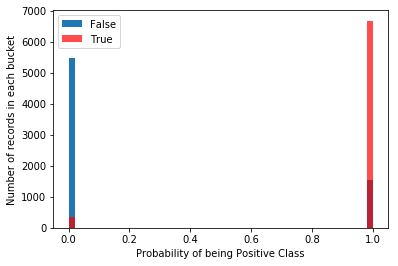

In [12]:
compare_estimators.plot_pred_probabs(pred_prob_knn, target_test, index_num=1)

The prediction confidence of the model has greatly improved. The predicted probabilities are almost ideal when oversampling is used.
The lower the probability of being in the positive class, the higher the tendency that that sample actually belongs to the negative class: as expected.

## Logistic Regression
The class probabilities when a logistic regression model was used were observed.

In [13]:
lr = LogisticRegression(random_state=0, solver='lbfgs', max_iter=7600)
lr.fit(data_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=7600, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

The predicted class probabilities of being in the positive class are observed.

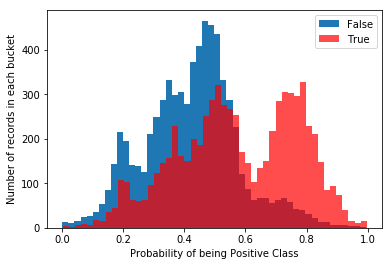

In [15]:
index_num = 1
pred_prob_lr=lr.predict_proba(data_test)[:,index_num]
compare_estimators.plot_pred_probabs(pred_prob_lr, target_test, index_num = 1)

The predicted probabilities of the positives are seen to have increased.However, there is still a lot of overlapping in the case of the logistic regression model.

## RandomForestClassifier

The Random forest classifier is fit on the training set of the data set. The parameter values used in the call of the RandomForestClassifier() estimator function are just default values.

In [16]:
rfc = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

classifier = rfc.fit(data_train, target_train)


The predicted class probabilities are plotted and visualised on a histogram.

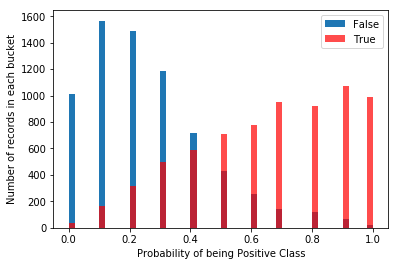

In [19]:
"""As said earlier, class1 is considered the positive class in this study and its predicted probabilities are 
found in the second column (index 1) of the predict_proba(data_test) result."""
index_num=1

pred_prob_rfc = classifier.predict_proba(data_test)[:,index_num]
compare_estimators.plot_pred_probabs(pred_prob_rfc, target_test, index_num=1)

Applying oversampling to the data has significantly increased the predicted probability of the positives. However, the predicted probabilities of the negatives have not been truncated to zero. As a result, there is a lot of overlapping between the positives and negatives.

# Part two : Comparison of classifiers based on predicted probabilities

The predicted class probabilities per classifier are plotted using the `class_probs()` function found in the `compare_estimators` module.

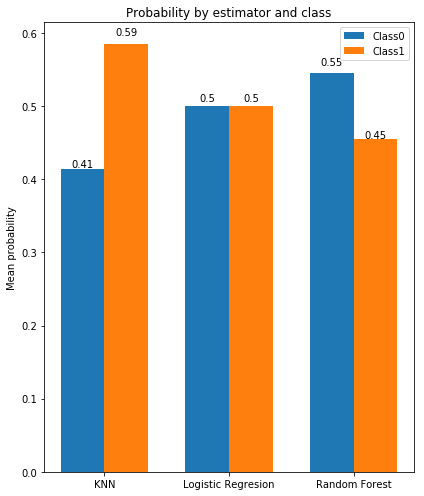

In [20]:
labels = ['KNN', 'Logistic Regresion', 'Random Forest']
estimators = [knn,lr,rfc]

compare_estimators.class_probs(labels, estimators, data_test)

The effect of oversampling the `defaults.csv` dataset has been an increase in the predicted probability of the minority class (0). However, the predicted probability of the majority class(1) has dropped significantly.
Overall, all the classifiers are seen to produce predicted probabilities that are more or less 0.5. This indicates that most of the predictions might just be guesses.
This study is inconclusive.